# Assignment #1

## Overview of our assignment
* Given a face image dataset, namely CelebA, you need to perform classification with it, using an MLP and multiple CNN architectures, and then report the results.
* We provide three models for classification, such as MLP, VGG, and ResNet-18, which can be used as the base architectures for your assignment.
* You should use the following three regularization techniques: 1) Dropout, 2) L2 normalization, and 3) L1 normalization, based upon the provided three models, and then report the results with regularization techniques that you will implement. 
* Also, you should apply the following three optimization methods: 1) SGD with Momentum, 2) AdaGrad, and 3) Adam, and then report the obtained results as well.

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

## Preparing the CelebA dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

Download link: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8

1) Download and unzip the file `./Img/img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `./Anno/list_attr_celeba.txt` file, which contains the class labels.

3) Download the `./Eval/list_eval_partition.txt` file, which contains  training/validation/test partitioning info.

Please make sure that, all your downloaded files (or unzipped folders) are located inside of the "./data" folder to run below codes.

For example,
* ./data/list_attr_celeba.txt
* ./data/list_eval_partition.txt
* ./data/img_align_celeba/{IMAGE_NAME}.jpg

In [2]:
df1 = pd.read_csv('./data/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0
df1.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


In [3]:
df2 = pd.read_csv('./data/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.head()

,Partition
Filename,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [4]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [5]:
df3.to_csv('./data/celeba-gender-partitions.csv')
df4 = pd.read_csv('./data/celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [6]:
df4.loc[df4['Partition'] == 0].to_csv('./data/celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('./data/celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('./data/celeba-gender-test.csv')

(218, 178, 3)


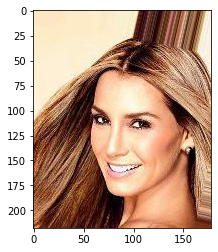

In [7]:
# Print sample image
img = Image.open('./data/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

## Implementing the DataLoader for training, validation, and test

In [8]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [9]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((32, 32)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='./data/celeba-gender-train.csv',
                              img_dir='./data/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='./data/celeba-gender-valid.csv',
                              img_dir='./data/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='./data/celeba-gender-test.csv',
                             img_dir='./data/img_align_celeba/',
                             transform=custom_transform)

BATCH_SIZE=256


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=6)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=6)

In [10]:
# Testing dataloader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 200
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 256
Epoch: 2 | Batch index: 0 | Batch size: 256
Epoch: 3 | Batch index: 0 | Batch size: 256
Epoch: 4 | Batch index: 0 | Batch size: 256
Epoch: 5 | Batch index: 0 | Batch size: 256
Epoch: 6 | Batch index: 0 | Batch size: 256
Epoch: 7 | Batch index: 0 | Batch size: 256
Epoch: 8 | Batch index: 0 | Batch size: 256
Epoch: 9 | Batch index: 0 | Batch size: 256
Epoch: 10 | Batch index: 0 | Batch size: 256
Epoch: 11 | Batch index: 0 | Batch size: 256
Epoch: 12 | Batch index: 0 | Batch size: 256
Epoch: 13 | Batch index: 0 | Batch size: 256
Epoch: 14 | Batch index: 0 | Batch size: 256
Epoch: 15 | Batch index: 0 | Batch size: 256
Epoch: 16 | Batch index: 0 | Batch size: 256
Epoch: 17 | Batch index: 0 | Batch size: 256
Epoch: 18 | Batch index: 0 | Batch size: 256
Epoch: 19 | Batch index: 0 | Batch size: 256
Epoch: 20 | Batch index: 0 | Batch size: 256
Epoch: 21 | Batch index: 0 | Batch size: 256
Epoch: 22 | Batch index: 0 | Batch size: 256
Epoch: 23 | Batch i

Epoch: 182 | Batch index: 0 | Batch size: 256
Epoch: 183 | Batch index: 0 | Batch size: 256
Epoch: 184 | Batch index: 0 | Batch size: 256
Epoch: 185 | Batch index: 0 | Batch size: 256
Epoch: 186 | Batch index: 0 | Batch size: 256
Epoch: 187 | Batch index: 0 | Batch size: 256
Epoch: 188 | Batch index: 0 | Batch size: 256
Epoch: 189 | Batch index: 0 | Batch size: 256
Epoch: 190 | Batch index: 0 | Batch size: 256
Epoch: 191 | Batch index: 0 | Batch size: 256
Epoch: 192 | Batch index: 0 | Batch size: 256
Epoch: 193 | Batch index: 0 | Batch size: 256
Epoch: 194 | Batch index: 0 | Batch size: 256
Epoch: 195 | Batch index: 0 | Batch size: 256
Epoch: 196 | Batch index: 0 | Batch size: 256
Epoch: 197 | Batch index: 0 | Batch size: 256
Epoch: 198 | Batch index: 0 | Batch size: 256
Epoch: 199 | Batch index: 0 | Batch size: 256
Epoch: 200 | Batch index: 0 | Batch size: 256


## Implementing models

In [11]:
# Hyperparameters
random_seed = 42
learning_rate = 0.001
num_epochs = 200

# Architecture
num_features = 32*32
num_classes = 2

# Results
train_accs = []
val_accs = []
costs = []

In [12]:
from models import mlp
from models import vgg
from models import resnet
#from models import dropout_mlp
#from models import dropout_vgg
#from models import dropout_resnet

In [13]:
# You need to specify the model that you want to use in here.

#model = mlp.MLP()                 # For MLP
#model = vgg.VGG16()               # For VGG
model = resnet.ResNet18()         # For ResNet18

model = model.to(device)

In [14]:
# You need to implement optimizers for this assignment,
# Note that you can directly load the optimizer that you want to use in PyTorch library

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #SGD
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #ADAM
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1) #ADAM w L2 norm 

## Training

In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
#        ### LOGGING
#        if not batch_idx % 50:
#            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
#                   %(epoch+1, num_epochs, batch_idx, 
#                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, valid_loader)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        costs.append(cost)
        print('Epoch: %03d/%03d |Cost: %.3f | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, num_epochs, cost, train_acc, val_acc))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/200 |Cost: 0.128 | Train: 96.130% | Valid: 96.517%
Time elapsed: 2.65 min
Epoch: 002/200 |Cost: 0.121 | Train: 96.663% | Valid: 96.713%
Time elapsed: 5.30 min
Epoch: 003/200 |Cost: 0.134 | Train: 97.509% | Valid: 97.443%
Time elapsed: 7.94 min
Epoch: 004/200 |Cost: 0.116 | Train: 98.347% | Valid: 97.740%
Time elapsed: 10.58 min
Epoch: 005/200 |Cost: 0.023 | Train: 98.197% | Valid: 97.488%
Time elapsed: 13.22 min
Epoch: 006/200 |Cost: 0.035 | Train: 98.670% | Valid: 97.513%
Time elapsed: 15.86 min
Epoch: 007/200 |Cost: 0.022 | Train: 99.147% | Valid: 97.926%
Time elapsed: 18.50 min
Epoch: 008/200 |Cost: 0.017 | Train: 99.257% | Valid: 98.002%
Time elapsed: 21.14 min
Epoch: 009/200 |Cost: 0.030 | Train: 99.370% | Valid: 97.720%
Time elapsed: 23.79 min
Epoch: 010/200 |Cost: 0.048 | Train: 99.317% | Valid: 97.599%
Time elapsed: 26.49 min
Epoch: 011/200 |Cost: 0.012 | Train: 99.481% | Valid: 97.644%
Time elapsed: 29.14 min
Epoch: 012/200 |Cost: 0.007 | Train: 99.635% | Valid: 97.

Epoch: 096/200 |Cost: 0.000 | Train: 99.990% | Valid: 98.294%
Time elapsed: 254.88 min
Epoch: 097/200 |Cost: 0.000 | Train: 99.980% | Valid: 98.203%
Time elapsed: 257.59 min
Epoch: 098/200 |Cost: 0.000 | Train: 99.883% | Valid: 98.052%
Time elapsed: 260.31 min
Epoch: 099/200 |Cost: 0.001 | Train: 99.991% | Valid: 98.279%
Time elapsed: 263.01 min
Epoch: 100/200 |Cost: 0.002 | Train: 99.666% | Valid: 97.413%
Time elapsed: 265.70 min
Epoch: 101/200 |Cost: 0.002 | Train: 99.990% | Valid: 98.158%
Time elapsed: 268.37 min


## Evaluation

In [22]:
with torch.set_grad_enabled(False): # save memory during inference
    test_acc = compute_accuracy(model, test_loader)
    print('Test accuracy: %.2f%%' % (test_acc))

Test accuracy: 97.86%


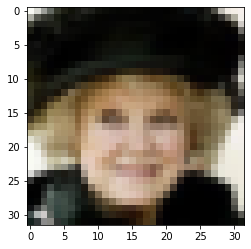

In [23]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [24]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 100.00%


## Visualization

You need to draw training curves of your models, and then insert the curves as well as the final results of your model in your report.

In [25]:
train_accs_np = []

for a in train_accs :
    train_accs_np.append(a.cpu().numpy().item(0))
    print(a.cpu().numpy().item(0))

96.13011932373047
96.66338348388672
97.50875091552734
98.34735870361328
98.19745635986328
98.6698989868164
99.14664459228516
99.2566146850586
99.37027740478516
99.31682586669922
99.4808578491211
99.63506317138672
99.72230529785156
99.80709075927734
99.82244110107422
99.84333801269531
99.80647277832031
99.76531219482422
99.84579467773438
99.74933624267578
99.87467193603516
99.81138610839844
99.77513885498047
99.87220764160156
99.78374481201172
99.85009765625
99.87834930419922
99.90660858154297
99.9035415649414
99.93303680419922
99.7905044555664
99.67254638671875
99.94532012939453
99.8660659790039
99.94654846191406
99.86791229248047
99.84394836425781
99.93180084228516
99.76654052734375
99.88080596923828
99.83042907714844
99.90231323242188
99.925048828125
99.95760345458984
99.88941192626953
99.9287338256836
99.82981872558594
99.9594497680664
99.91951751708984
99.94715881347656
99.89862060546875
99.91152954101562
99.7911148071289
99.97112274169922
99.96989440917969
99.97235107421875
99.963

In [26]:
val_accs_np = []

for a in val_accs :
    val_accs_np.append(a.cpu().numpy().item(0))
    print(a.cpu().numpy().item(0))

96.51683807373047
96.71314239501953
97.4429931640625
97.7399673461914
97.48829650878906
97.51345825195312
97.92620849609375
98.001708984375
97.71983337402344
97.59903717041016
97.64433288574219
97.77519989013672
97.89097595214844
98.0268783569336
97.92620849609375
98.03191375732422
98.10741424560547
97.69467163085938
97.87084197998047
97.65440368652344
97.91614532470703
97.88090515136719
97.96647644042969
98.01680755615234
97.74500274658203
98.12251281738281
98.08224487304688
98.12251281738281
98.08224487304688
98.03694152832031
97.84567260742188
97.83560943603516
98.20304870605469
98.08224487304688
98.10741424560547
98.01680755615234
97.87084197998047
98.001708984375
97.90607452392578
97.95640563964844
97.80037689208984
98.0621109008789
97.93124389648438
98.05204010009766
98.0268783569336
97.94634246826172
97.9413070678711
98.00674438476562
97.9765396118164
98.01680755615234
98.03694152832031
97.96144104003906
97.87084197998047
98.09735107421875
98.0923080444336
98.16278076171875
98.0

In [29]:
costs_np = []

for a in costs :
    costs_np.append(a.cpu().detach().numpy().item(0))
    print(a.cpu().detach().numpy().item(0))

0.12811753153800964
0.12138722091913223
0.1335936337709427
0.11620641499757767
0.023195777088403702
0.03537478297948837
0.021615957841277122
0.016643309965729713
0.030260544270277023
0.04781147465109825
0.01216737087816
0.007483295630663633
0.009621178731322289
0.005944002885371447
0.022249748930335045
0.0022864295169711113
0.001309750135987997
0.00462238397449255
0.0014939267421141267
0.0028498286847025156
0.023410635069012642
0.004621659871190786
0.024455152451992035
0.0003494595002848655
0.00996061135083437
0.0011663747718557715
0.0002009787131100893
0.00012106318899895996
0.006673663388937712
0.0003911961684934795
0.0019088790286332369
0.00017052619659807533
0.0008104472071863711
0.0008653450640849769
0.00036728798295371234
0.00810387171804905
0.00031423562904819846
0.012718843296170235
0.0051407781429588795
0.0013514063321053982
0.0013758100103586912
6.8600629674619995e-06
0.0009138152236118913
2.6670255465433e-05
2.9271646781126037e-05
0.0008521064883098006
0.00011450048623373732

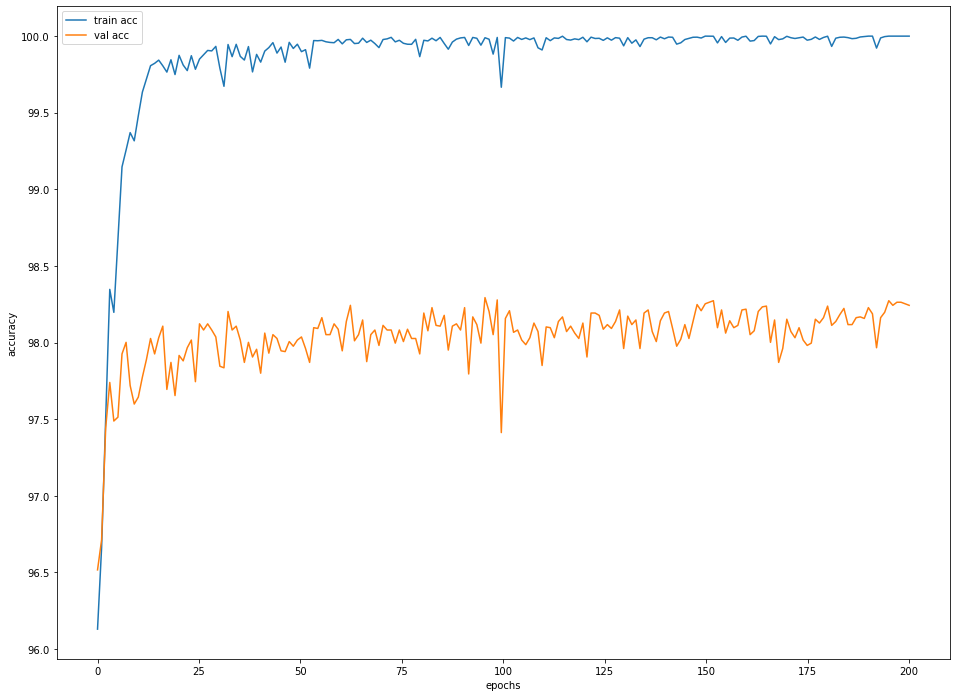

In [30]:
#plt.rcParams['figure.figsize'] = [100, 80]
fig, ax = plt.subplots(figsize=(16, 12))
x = np.linspace(0, 200, 200)
ax.plot(x, train_accs_np, label='train acc')
ax.plot(x, val_accs_np, label='val acc')
#ax.plot(x, test_accs_np, label='test acc')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy') 
ax.legend()

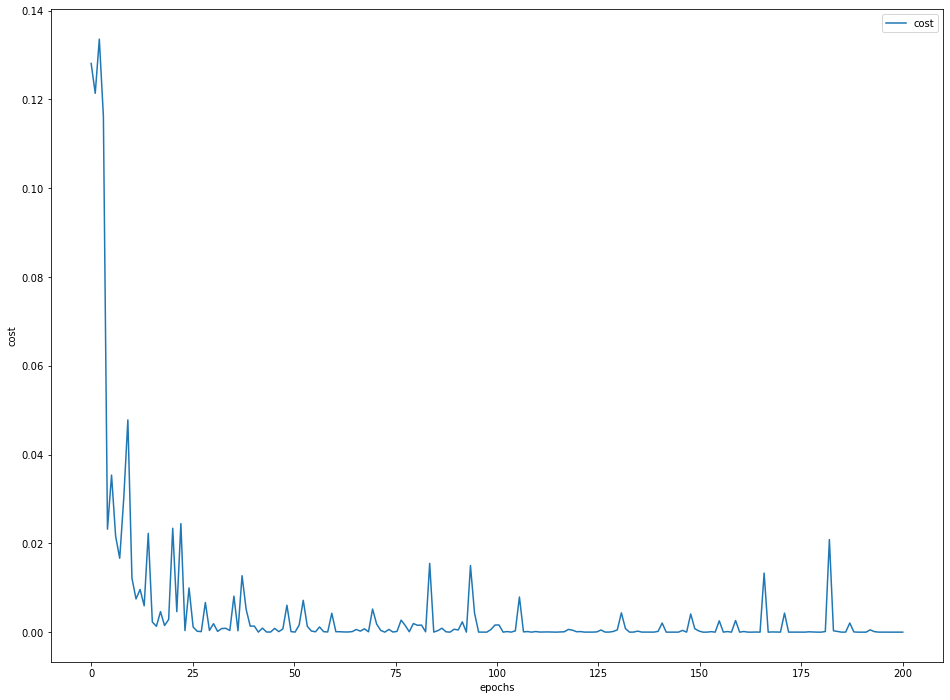

In [32]:
fig, ax = plt.subplots(figsize=(16, 12))
x = np.linspace(0, 200, 200)
ax.plot(x, costs_np, label='cost')
#ax.plot(x, test_accs_np, label='test acc')
ax.set_xlabel('epochs')
ax.set_ylabel('cost') 
ax.legend()